In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from collections import defaultdict, Counter
import os
from datetime import timedelta
import plotly.express as px


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [31]:
data = pd.read_csv('more_resource.csv')
data.drop(columns=['Unnamed: 0'], inplace=True)
data.head(3)

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,datetime,month,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,water_equiv_snowfall,station_pressure,sealevel_pressure,wind_speed,wind_direction,avg_wind_speed,wind_direction_cos,wind_direction_sin,TS,RA,DZ,FG,BR,HZ,VC,MD,lat,lon,spray_dist,has_spray,spray_lat_diff,spray_lon_diff,station_dist,station_lat_diff,station_lon_diff,pre_spray_dist,pre_has_spray,pre_spray_lat_diff,pre_spray_lon_diff,population,median_income,population_density
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,2007-05-29,5,88,60,74.0,10.0,58,65.0,0.0,9.0,421,1917,0.0,29.39,30.11,5.8,180,6.5,-1.0,1.224647e-16,0,0,0,0,1,1,0,0,41.995,-87.933,1.414,0,1.0,1.0,0.138026,-0.040310,0.132009,1.414,0,1.0,1.0,75604,55324.0,10611.96
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,2007-05-29,5,88,60,74.0,10.0,58,65.0,0.0,9.0,421,1917,0.0,29.39,30.11,5.8,180,6.5,-1.0,1.224647e-16,0,0,0,0,1,1,0,0,41.995,-87.933,1.414,0,1.0,1.0,0.138026,-0.040310,0.132009,1.414,0,1.0,1.0,75604,55324.0,10611.96
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0,2007-05-29,5,88,60,74.0,10.0,58,65.0,0.0,9.0,421,1917,0.0,29.39,30.11,5.8,180,6.5,-1.0,1.224647e-16,0,0,0,0,1,1,0,0,41.995,-87.933,1.414,0,1.0,1.0,0.163721,-0.000009,0.163721,1.414,0,1.0,1.0,29043,72086.0,5741.46


In [32]:
data['Trap'].unique().size

136

In [33]:
data['AddressNumberAndStreet'].unique().size

138

In [34]:
data.shape[0]

10506

In [35]:
data['WnvPresent'].sum()

551

Our dataset is very unbalanced. one can do oversampling.

In [36]:
data.drop(columns = ['Date', 'datetime', 'Sunrise', 'Sunset', 'lat', 'lon', 'Trap', 'AddressAccuracy', 'Address', 'HZ', 'RA', 'spray_dist','has_spray','spray_lat_diff','spray_lon_diff'], inplace=True)

y = data['WnvPresent']

X = data.drop(columns=['WnvPresent'])

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=91, stratify=y.values)
X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)

In [38]:
def oversample(X, y):
    num_samples = 5000
    a, b = X.loc[y.values==0, :].copy(), X.loc[y.values==1, :].copy()
    sample_a = a.sample(num_samples, replace=True, random_state=41)
    sample_b = b.sample(num_samples, replace=True, random_state=41)
    y_a = np.zeros(num_samples)
    y_b = np.ones(num_samples)
    return pd.concat([sample_a, sample_b]), np.concatenate([y_a, y_b])

def undersample(X, y):
    a, b = X.loc[y.values==0, :].copy(), X.loc[y.values==1, :].copy()
    a_size = b.shape[0]
    sample_a = a.sample(a_size, replace=True, random_state=41)
    y_a = np.zeros(a_size)
    y_b = np.ones(a_size)
    return pd.concat([sample_a, b]), np.concatenate([y_a, y_b])

In [39]:
def group_region(df):
    grp = []
    for i in range(0,df.shape[0]):
        x, y = df['Latitude'].values[i], df['Longitude'].values[i]
        if y<=87.778:
            if x<=41.964:
                if x<=41.943:
                    grp.append(0)
                else:
                    grp.append(1)
            else:
                if y<=-87.796:
                    grp.append(2)
                else:
                    grp.append(3)
        else:
            if x<=41.711:
                if y<=-87.69:
                    grp.append(4)
                else:
                    grp.append(5)
            else:
                if y<=-87.722:
                    grp.append(6)
                else:
                    grp.append(7)
    return grp                

In [40]:
X_train['region_grp'] = group_region(X_train)
X_test['region_grp'] = group_region(X_test)

In [41]:
X_train.head()

,Species,Block,Street,AddressNumberAndStreet,Latitude,Longitude,NumMosquitos,month,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,water_equiv_snowfall,station_pressure,sealevel_pressure,wind_speed,wind_direction,avg_wind_speed,wind_direction_cos,wind_direction_sin,TS,DZ,FG,BR,VC,MD,station_dist,station_lat_diff,station_lon_diff,pre_spray_dist,pre_has_spray,pre_spray_lat_diff,pre_spray_lon_diff,population,median_income,population_density,region_grp
0,CULEX PIPIENS/RESTUANS,45,N CAMPBELL AVE,"4500 N CAMPBELL AVE, Chicago, IL",41.963976,-87.691810,2,8,92,69,81.0,8.0,62,69.0,0.0,16.0,0.0,29.29,30.00,3.5,90,4.1,6.123234e-17,1.000000,0,0,0,0,0,0,0.243177,-0.031024,0.241190,1.414,0,1.0,1.0,78820,57252.0,23681.910,1
1,CULEX TERRITANS,53,N STREETER DR,"5300 N STREETER DR, Chicago, IL",41.891126,-87.611560,1,9,90,68,79.0,18.0,63,68.0,0.0,14.0,0.0,29.27,29.99,11.4,190,11.9,-9.848078e-01,-0.173648,0,0,0,0,0,1,0.337807,-0.103874,0.321440,1.414,0,1.0,1.0,33937,85074.0,17783.870,0
2,CULEX PIPIENS,11,W CHICAGO,"1100 W CHICAGO, Chicago, IL",41.896282,-87.655232,5,8,89,66,78.0,8.0,64,69.0,0.0,13.0,0.0,29.29,30.01,3.9,100,4.7,-1.736482e-01,0.984808,0,0,0,1,0,0,0.294789,-0.098718,0.277768,1.414,0,1.0,1.0,20191,70188.0,56.465,0
3,CULEX PIPIENS/RESTUANS,35,W 51ST ST,"3500 W 51ST ST, Chicago, IL",41.800737,-87.711880,5,10,83,56,70.0,10.0,56,62.0,0.0,5.0,0.0,29.39,30.03,4.6,170,5.9,-9.848078e-01,0.173648,0,0,0,0,0,0,0.042741,0.014737,0.040120,1.414,0,1.0,1.0,86715,38196.0,12507.780,0
4,CULEX RESTUANS,58,N WESTERN AVE,"5800 N WESTERN AVE, Chicago, IL",41.986921,-87.689778,2,9,84,58,71.0,7.0,55,61.0,0.0,6.0,0.0,29.34,30.07,0.1,330,2.1,8.660254e-01,-0.500000,0,0,0,0,0,1,0.243356,-0.008079,0.243222,1.414,0,1.0,1.0,78820,57252.0,23681.910,3


In [42]:
resample_X_train, resample_y_train = oversample(X_train, y_train)

In [43]:
undersample_X_train, undersample_y_train = undersample(X_train, y_train)

In [44]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

transformer = ColumnTransformer(transformers = [('categorical', OrdinalEncoder(dtype=np.int64,
                                                                               handle_unknown='use_encoded_value', unknown_value=-1), ['Species', 'Block', 'Street', 'AddressNumberAndStreet'])],
                               remainder='passthrough', verbose_feature_names_out=False)

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from lightgbm import LGBMClassifier


rf = RandomForestClassifier(n_estimators=400, oob_score=True, class_weight={0:1, 1:10})

pipe = Pipeline([('tr', transformer), ('rf', rf)])



param = {'rf__criterion':['gini', 'entropy'], 'rf__max_depth':[16, 32, 64], 'rf__min_samples_leaf':[2,4,8],
         'rf__min_samples_split':[2,4,8]}

grid = GridSearchCV(pipe, param, scoring='balanced_accuracy')



In [46]:
grid.fit(undersample_X_train, undersample_y_train)

GridSearchCV(estimator=Pipeline(steps=[('tr',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('categorical',
                                                                         OrdinalEncoder(dtype=<class 'numpy.int64'>,
                                                                                        handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         ['Species',
                                                                          'Block',
                                                                          'Street',
                                                                          'AddressNumberAndStreet'])],
                                                          verbose_feature_names_

In [47]:
grid.best_params_

{'rf__criterion': 'entropy',
 'rf__max_depth': 64,
 'rf__min_samples_leaf': 2,
 'rf__min_samples_split': 2}

In [48]:
best_rf = grid.best_estimator_

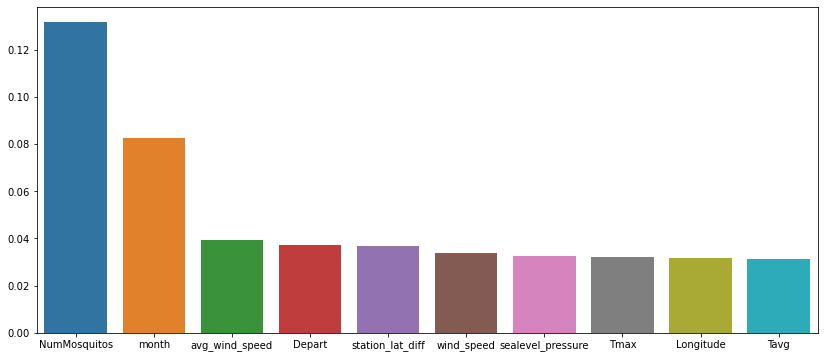

In [49]:
best_rf.fit(undersample_X_train, undersample_y_train)

f_importance = pd.Series(index=undersample_X_train.columns.values, data = best_rf.get_params()['rf'].feature_importances_)

f_importance = f_importance.sort_values(ascending=False)

plt.figure(figsize=(14,6))
sns.barplot(x=f_importance.index[:10], y=f_importance.values[:10])
plt.show()

In [50]:
y_pred = best_rf.predict(X_test)

In [51]:
cm = confusion_matrix(y_test.values, y_pred, labels=[0,1])
print(cm)

print(classification_report(y_test.values, y_pred))

[[1378  614]
 [  10  100]]
              precision    recall  f1-score   support

           0       0.99      0.69      0.82      1992
           1       0.14      0.91      0.24       110

    accuracy                           0.70      2102
   macro avg       0.57      0.80      0.53      2102
weighted avg       0.95      0.70      0.79      2102



In [52]:
pipe = Pipeline([('tr', transformer), ('lgbm', LGBMClassifier())])


param = {'lgbm__max_depth':[12, 16, 20] ,'lgbm__learning_rate':[0.05, 0.1, 0.2], 'lgbm__n_estimators':[400, 800], 
        'lgbm__min_child_samples':[2, 4, 8], 'lgbm__scale_pos_weight':[2,4,8]}

grid = GridSearchCV(pipe, param, scoring = 'balanced_accuracy')

In [53]:
grid.fit(undersample_X_train, undersample_y_train)

GridSearchCV(estimator=Pipeline(steps=[('tr',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('categorical',
                                                                         OrdinalEncoder(dtype=<class 'numpy.int64'>,
                                                                                        handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         ['Species',
                                                                          'Block',
                                                                          'Street',
                                                                          'AddressNumberAndStreet'])],
                                                          verbose_feature_names_

In [54]:
grid.best_params_

{'lgbm__learning_rate': 0.1,
 'lgbm__max_depth': 12,
 'lgbm__min_child_samples': 2,
 'lgbm__n_estimators': 800,
 'lgbm__scale_pos_weight': 4}

In [55]:
best_lgbm = grid.best_estimator_

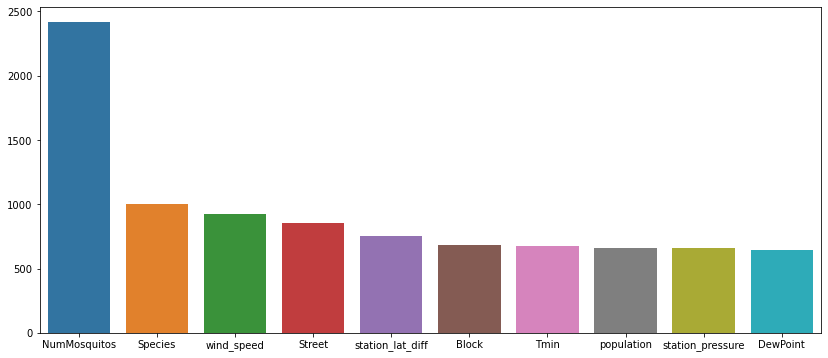

In [56]:
best_lgbm.fit(undersample_X_train, undersample_y_train)

f_importance = pd.Series(index=undersample_X_train.columns.values, data = best_lgbm.get_params()['lgbm'].feature_importances_)

f_importance = f_importance.sort_values(ascending=False)

plt.figure(figsize=(14,6))
sns.barplot(x=f_importance.index[:10], y=f_importance.values[:10])
plt.show()

In [57]:
y_pred = best_lgbm.predict(X_test)

cm = confusion_matrix(y_test.values, y_pred, labels=[0,1])
print(cm)

print(classification_report(y_test.values, y_pred))

[[1449  543]
 [  17   93]]
              precision    recall  f1-score   support

           0       0.99      0.73      0.84      1992
           1       0.15      0.85      0.25       110

    accuracy                           0.73      2102
   macro avg       0.57      0.79      0.54      2102
weighted avg       0.94      0.73      0.81      2102



In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

rf = RandomForestClassifier(n_estimators=400, oob_score=True, class_weight={0:1, 1:20})

pipe = Pipeline([('tr', transformer), ('rf', rf)])

pipe.fit(X_train, y_train)



Pipeline(steps=[('tr',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OrdinalEncoder(dtype=<class 'numpy.int64'>,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['Species', 'Block', 'Street',
                                                   'AddressNumberAndStreet'])],
                                   verbose_feature_names_out=False)),
                ('rf',
                 RandomForestClassifier(class_weight={0: 1, 1: 20},
                                        n_estimators=400, oob_score=True))])

First let us try setting class weight to deal with unbalanced data, next we shall try oversampleing to deal with class imbalance

In [16]:
pipe.score(X_test, y_test)

0.9257849666983825

In [17]:
pipe.get_params()

{'memory': None,
 'steps': [('tr', ColumnTransformer(remainder='passthrough',
                     transformers=[('categorical',
                                    OrdinalEncoder(dtype=<class 'numpy.int64'>,
                                                   handle_unknown='use_encoded_value',
                                                   unknown_value=-1),
                                    ['Species', 'Block', 'Street',
                                     'AddressNumberAndStreet'])],
                     verbose_feature_names_out=False)),
  ('rf',
   RandomForestClassifier(class_weight={0: 1, 1: 20}, n_estimators=400,
                          oob_score=True))],
 'verbose': False,
 'tr': ColumnTransformer(remainder='passthrough',
                   transformers=[('categorical',
                                  OrdinalEncoder(dtype=<class 'numpy.int64'>,
                                                 handle_unknown='use_encoded_value',
                                      

In [18]:
from sklearn.model_selection import GridSearchCV

param = {'rf__criterion':['gini', 'entropy'], 'rf__max_depth':[16, 32, 64], 'rf__min_samples_leaf':[2,4,8],
         'rf__min_samples_split':[2,4,8]}

grid = GridSearchCV(pipe, param, scoring='balanced_accuracy')


In [19]:
grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tr',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('categorical',
                                                                         OrdinalEncoder(dtype=<class 'numpy.int64'>,
                                                                                        handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         ['Species',
                                                                          'Block',
                                                                          'Street',
                                                                          'AddressNumberAndStreet'])],
                                                          verbose_feature_names_

In [20]:
grid.best_params_

{'rf__criterion': 'gini',
 'rf__max_depth': 16,
 'rf__min_samples_leaf': 8,
 'rf__min_samples_split': 8}

In [21]:
best_rf = grid.best_estimator_

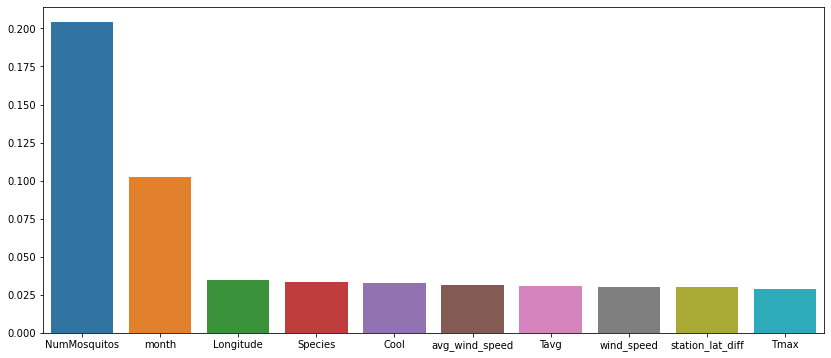

In [22]:
best_rf.fit(X_train, y_train)

f_importance = pd.Series(index=X_train.columns.values, data = best_rf.get_params()['rf'].feature_importances_)

f_importance = f_importance.sort_values(ascending=False)

plt.figure(figsize=(14,6))
sns.barplot(x=f_importance.index[:10], y=f_importance.values[:10])
plt.show()

In [23]:
from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix

y_pred = best_rf.predict(X_test)

In [24]:
cm = confusion_matrix(y_test.values, y_pred, labels=[0,1])
print(cm)

[[1793  199]
 [  42   68]]


In [25]:
print(classification_report(y_test.values, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.90      0.94      1992
           1       0.25      0.62      0.36       110

    accuracy                           0.89      2102
   macro avg       0.62      0.76      0.65      2102
weighted avg       0.94      0.89      0.91      2102



In [26]:
rf = RandomForestClassifier(n_estimators=400)

pipe = Pipeline([('tr', transformer), ('rf', rf)])

param = {'rf__criterion':['gini', 'entropy'], 'rf__max_depth':[16, 32, 64], 'rf__min_samples_leaf':[2,4,8],
         'rf__min_samples_split':[2,4,8]}

grid = GridSearchCV(pipe, param, scoring='balanced_accuracy')


In [27]:
grid.fit(resample_X_train, resample_y_train)

GridSearchCV(estimator=Pipeline(steps=[('tr',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('categorical',
                                                                         OrdinalEncoder(dtype=<class 'numpy.int64'>,
                                                                                        handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         ['Species',
                                                                          'Block',
                                                                          'Street',
                                                                          'AddressNumberAndStreet'])],
                                                          verbose_feature_names_

In [28]:
grid.best_params_

{'rf__criterion': 'gini',
 'rf__max_depth': 32,
 'rf__min_samples_leaf': 2,
 'rf__min_samples_split': 2}

In [29]:
best_rf = grid.best_estimator_

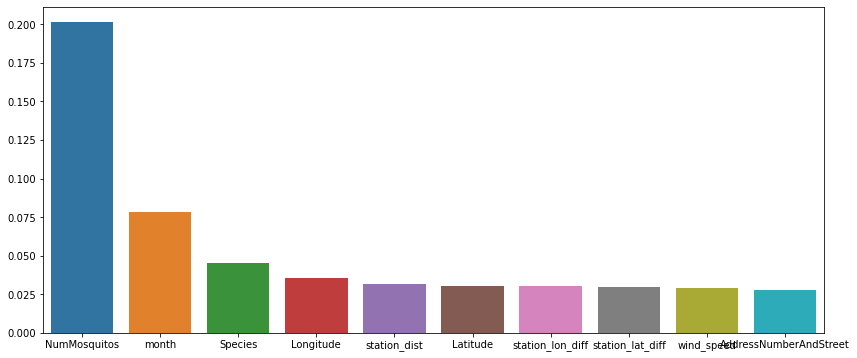

In [30]:
best_rf.fit(resample_X_train, resample_y_train)

f_importance = pd.Series(index=resample_X_train.columns.values, data = best_rf.get_params()['rf'].feature_importances_)

f_importance = f_importance.sort_values(ascending=False)

plt.figure(figsize=(14,6))
sns.barplot(x=f_importance.index[:10], y=f_importance.values[:10])
plt.show()

In [31]:
y_pred = best_rf.predict(X_test)

cm = confusion_matrix(y_test.values, y_pred, labels=[0,1])
print(cm)

print(classification_report(y_test.values, y_pred))

[[1801  191]
 [  50   60]]
              precision    recall  f1-score   support

           0       0.97      0.90      0.94      1992
           1       0.24      0.55      0.33       110

    accuracy                           0.89      2102
   macro avg       0.61      0.72      0.63      2102
weighted avg       0.93      0.89      0.91      2102



In [32]:
from sklearn.ensemble import GradientBoostingClassifier


gb = GradientBoostingClassifier(n_estimators=400)

pipe = Pipeline([('tr', transformer), ('gb', gb)])


In [33]:
pipe.get_params()

{'memory': None,
 'steps': [('tr', ColumnTransformer(remainder='passthrough',
                     transformers=[('categorical',
                                    OrdinalEncoder(dtype=<class 'numpy.int64'>,
                                                   handle_unknown='use_encoded_value',
                                                   unknown_value=-1),
                                    ['Species', 'Block', 'Street',
                                     'AddressNumberAndStreet'])],
                     verbose_feature_names_out=False)),
  ('gb', GradientBoostingClassifier(n_estimators=400))],
 'verbose': False,
 'tr': ColumnTransformer(remainder='passthrough',
                   transformers=[('categorical',
                                  OrdinalEncoder(dtype=<class 'numpy.int64'>,
                                                 handle_unknown='use_encoded_value',
                                                 unknown_value=-1),
                                  ['Spe

In [34]:
param = {'gb__learning_rate':[0.16, 0.24], 'gb__max_depth':[12, 20],
         'gb__min_samples_leaf':[2,4,8], 'gb__min_samples_split':[2,4,8]}

grid = GridSearchCV(pipe, param, scoring='balanced_accuracy')


In [35]:
grid.fit(resample_X_train, resample_y_train)

GridSearchCV(estimator=Pipeline(steps=[('tr',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('categorical',
                                                                         OrdinalEncoder(dtype=<class 'numpy.int64'>,
                                                                                        handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         ['Species',
                                                                          'Block',
                                                                          'Street',
                                                                          'AddressNumberAndStreet'])],
                                                          verbose_feature_names_

In [36]:
grid.best_params_

{'gb__learning_rate': 0.24,
 'gb__max_depth': 12,
 'gb__min_samples_leaf': 2,
 'gb__min_samples_split': 4}

In [37]:
best_gb = grid.best_estimator_

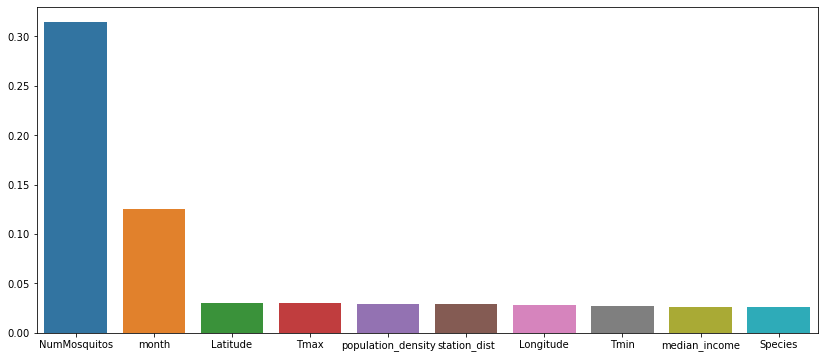

In [38]:
best_gb.fit(resample_X_train, resample_y_train)

f_importance = pd.Series(index=resample_X_train.columns.values, data = best_gb.get_params()['gb'].feature_importances_)

f_importance = f_importance.sort_values(ascending=False)

plt.figure(figsize=(14,6))
sns.barplot(x=f_importance.index[:10], y=f_importance.values[:10])
plt.show()

In [39]:
y_pred = best_gb.predict(X_test)

cm = confusion_matrix(y_test.values, y_pred, labels=[0,1])
print(cm)

print(classification_report(y_test.values, y_pred))

[[1856  136]
 [  63   47]]
              precision    recall  f1-score   support

           0       0.97      0.93      0.95      1992
           1       0.26      0.43      0.32       110

    accuracy                           0.91      2102
   macro avg       0.61      0.68      0.63      2102
weighted avg       0.93      0.91      0.92      2102



In [64]:
from lightgbm import LGBMClassifier

pipe = Pipeline([('tr', transformer), ('lgbm', LGBMClassifier())])


param = {'lgbm__max_depth':[12, 16, 20] ,'lgbm__learning_rate':[0.1, 0.2,0.4], 'lgbm__n_estimators':[400, 600], 
        'lgbm__min_child_samples':[2,4], 'lgbm__scale_pos_weight':[15, 25]}

grid = GridSearchCV(pipe, param, scoring = 'balanced_accuracy')

In [65]:
grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tr',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('categorical',
                                                                         OrdinalEncoder(dtype=<class 'numpy.int64'>,
                                                                                        handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         ['Species',
                                                                          'Block',
                                                                          'Street',
                                                                          'AddressNumberAndStreet'])],
                                                          verbose_feature_names_

In [66]:
grid.best_params_

{'lgbm__learning_rate': 0.1,
 'lgbm__max_depth': 20,
 'lgbm__min_child_samples': 4,
 'lgbm__n_estimators': 400,
 'lgbm__scale_pos_weight': 25}

In [67]:
best_lgbm = grid.best_estimator_

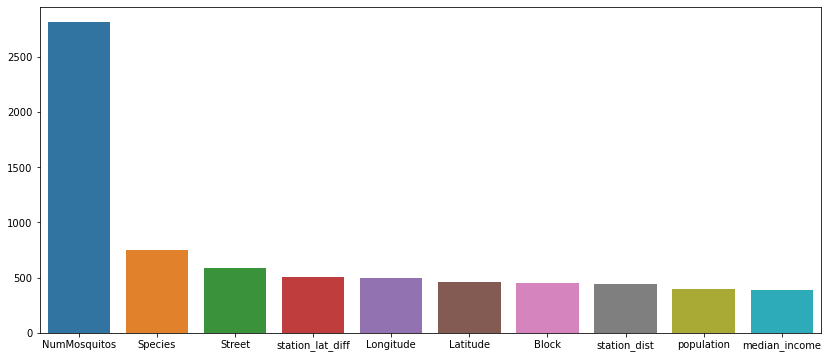

In [68]:
best_lgbm.fit(X_train, y_train)

f_importance = pd.Series(index=X_train.columns.values, data = best_lgbm.get_params()['lgbm'].feature_importances_)

f_importance = f_importance.sort_values(ascending=False)

plt.figure(figsize=(14,6))
sns.barplot(x=f_importance.index[:10], y=f_importance.values[:10])
plt.show()

In [69]:
y_pred = best_lgbm.predict(X_test)

cm = confusion_matrix(y_test.values, y_pred, labels=[0,1])
print(cm)

print(classification_report(y_test.values, y_pred))

[[1853  139]
 [  58   52]]
              precision    recall  f1-score   support

           0       0.97      0.93      0.95      1992
           1       0.27      0.47      0.35       110

    accuracy                           0.91      2102
   macro avg       0.62      0.70      0.65      2102
weighted avg       0.93      0.91      0.92      2102



In [70]:
from lightgbm import LGBMClassifier

pipe = Pipeline([('tr', transformer), ('lgbm', LGBMClassifier())])


param = {'lgbm__max_depth':[12, 16, 20] ,'lgbm__learning_rate':[0.1,0.2,0.4], 'lgbm__n_estimators':[400, 600], 
        'lgbm__min_child_samples':[2,4,6]}

grid = GridSearchCV(pipe, param, scoring='balanced_accuracy')

In [71]:
grid.fit(resample_X_train, resample_y_train)

GridSearchCV(estimator=Pipeline(steps=[('tr',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('categorical',
                                                                         OrdinalEncoder(dtype=<class 'numpy.int64'>,
                                                                                        handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         ['Species',
                                                                          'Block',
                                                                          'Street',
                                                                          'AddressNumberAndStreet'])],
                                                          verbose_feature_names_

In [72]:
grid.best_params_

{'lgbm__learning_rate': 0.2,
 'lgbm__max_depth': 20,
 'lgbm__min_child_samples': 6,
 'lgbm__n_estimators': 600}

In [73]:
best_lgbm = grid.best_estimator_

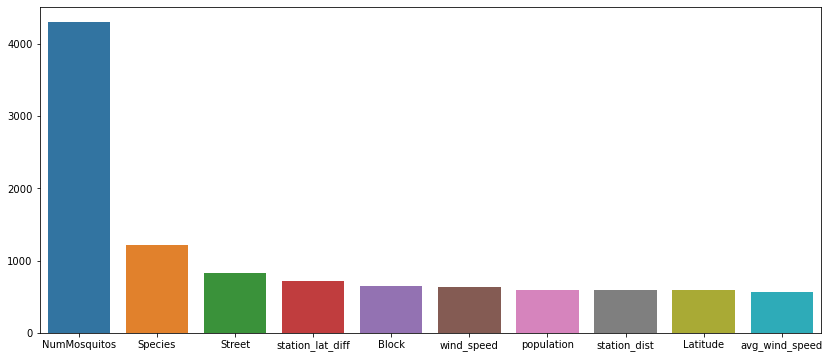

In [74]:
best_lgbm.fit(resample_X_train, resample_y_train)

f_importance = pd.Series(index=resample_X_train.columns.values, data = best_lgbm.get_params()['lgbm'].feature_importances_)

f_importance = f_importance.sort_values(ascending=False)

plt.figure(figsize=(14,6))
sns.barplot(x=f_importance.index[:10], y=f_importance.values[:10])
plt.show()

In [75]:
y_pred = best_lgbm.predict(X_test)

cm = confusion_matrix(y_test.values, y_pred, labels=[0,1])
print(cm)

print(classification_report(y_test.values, y_pred))

[[1842  150]
 [  58   52]]
              precision    recall  f1-score   support

           0       0.97      0.92      0.95      1992
           1       0.26      0.47      0.33       110

    accuracy                           0.90      2102
   macro avg       0.61      0.70      0.64      2102
weighted avg       0.93      0.90      0.91      2102

